In [11]:
import os
import pyspark
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat, lit
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [12]:
'''ALS'''
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [15]:
'''Report'''
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
'''Pandas'''
import pandas as pd

In [16]:
'''
global paths
'''
datasets_path = os.path.join('..','movie_recommendation_system', 'datasets')
complete_ratings_file = os.path.join(datasets_path, 'ml-latest', 'ratings.csv')
tags_file = os.path.join(datasets_path, 'ml-latest', 'tags.csv')
links_file = os.path.join(datasets_path, 'ml-latest','links.csv')
movies_file = os.path.join(datasets_path, 'ml-latest', 'movies.csv')

In [17]:
'''
load pyspark
'''
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark = SparkSession.builder.appName("Spark_Processor").config("spark.redis.port", "6379").config("spark.jars", "spark-redis-branch-2.4/target/spark-redis_2.11-2.5.0-SNAPSHOT-jar-with-dependencies.jar").getOrCreate()
conf = pyspark.SparkConf()
sc = spark.sparkContext

In [18]:
def sample_rating():
    ratingschema = StructType()\
    .add("userId", IntegerType(), True)\
    .add("movieId", IntegerType(), True)\
    .add("rating", DoubleType(), True)\
    .add("timeStamp", IntegerType(), True)
    ratingdf = spark.read.format("csv")\
    .option("header",True)\
    .schema(ratingschema)\
    .load(complete_ratings_file)
    ratingforals = ratingdf.drop("timeStamp")
    (training, test) = ratingforals.randomSplit([0.2, 0.8])
    return training

In [61]:
'''evaluate rmse from lower rank to upper rank'''
def rank_rmse(lower, upper):
    data = sample_rating()
    ratingforals = data.drop("timeStamp")
    (training, test) = ratingforals.randomSplit([0.8, 0.2])
    result = []
    for r in range(lower,upper, 10):
        als = ALS(maxIter=3, rank = r, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", 
          coldStartStrategy="drop")
        model = als.fit(training)
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
        result.append(evaluator.evaluate(predictions))
    return result

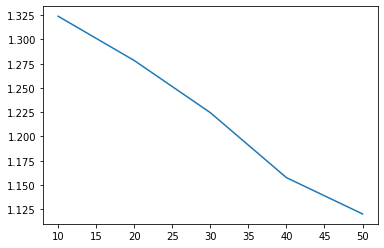

In [66]:
''' Report : test rank from 10(default) to 50 '''
rank_list = list(range(50, 9, -10))
rmse_list = rank_rmse(10, 51)
plt.plot(rank_list, rmse_list)
plt.show()

In [ ]:
class ALS_Model:
    '''
    data: rating dataframe
    '''
    def __init__(self, data):
        this.als = ALS(maxIter=3, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", 
          coldStartStrategy="drop")
        this.ratingforals = data.drop("timeStamp")
        this.model = als.fit(this.ratingforals)
    def recommendForUser(self, userId):
    '''
    get a recommendation for a user
    
    userId: integer value for a user id
    result: recommendedMovieID: list of movie ID that a userID gets recommended
    '''
        user = this.ratingforals.select("userId").distinct().filter(this.ratingforals.userId == userId)
        userSubsetRecs = model.recommendForUserSubset(user, 10)
        recommendations = list(userSubsetRecs.select('recommendations').toPandas()['recommendations'])
        recommendations = recommendations[0]
        recommendedMovieID = []
        for row in range(len(recommendations)):
            recommendedMovieId.append(row[0])
        return recommendedMovieID

In [19]:
# example of implementation
data = sample_rating()
ratingforals = data.drop("timeStamp")
(training, test) = ratingforals.randomSplit([0.5, 0.5])
als = ALS(maxIter=3, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", 
          coldStartStrategy="drop")
model = als.fit(training)
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   148|[[57946, 35.16254...|
|   463|[[47904, 19.74903...|
|   471|[[57946, 31.60759...|
|   496|[[115973, 33.9138...|
|   833|[[25789, 30.95429...|
|  1088|[[57946, 37.27958...|
|  1238|[[57946, 36.76107...|
|  1342|[[86715, 29.21999...|
|  1580|[[57946, 36.03212...|
|  1591|[[57946, 42.09615...|
|  1645|[[27884, 46.91272...|
|  1829|[[57946, 39.14211...|
|  1959|[[86715, 33.26827...|
|  2122|[[113370, 36.8535...|
|  2142|[[26073, 38.12136...|
|  2366|[[57946, 27.83738...|
|  2659|[[57946, 45.26], ...|
|  2866|[[57946, 52.85083...|
|  3175|[[115973, 31.7807...|
|  3749|[[115973, 40.5823...|
+------+--------------------+
only showing top 20 rows



In [39]:
# example of selecting userID
users1 = ratingforals.select(als.getUserCol()).distinct().filter(ratingforals.userId == 148)
users1.show()

+------+
|userId|
+------+
|   148|
+------+



In [46]:
userSubsetRecs = model.recommendForUserSubset(users1, 10)

In [54]:
recommendations = list(userSubsetRecs.select('recommendations').toPandas()['recommendations'])
recommendations = recommendations[0]

In [63]:
# example of getting recommended movies (the data format is pyspark DataFrame)
recommendations

[Row(movieId=57946, rating=35.16254806518555),
 Row(movieId=86715, rating=31.929285049438477),
 Row(movieId=115973, rating=30.611061096191406),
 Row(movieId=185659, rating=28.117338180541992),
 Row(movieId=156771, rating=26.829761505126953),
 Row(movieId=5518, rating=26.517826080322266),
 Row(movieId=84223, rating=25.6900634765625),
 Row(movieId=25759, rating=25.593900680541992),
 Row(movieId=89896, rating=25.101810455322266),
 Row(movieId=174565, rating=25.083829879760742)]